In [3]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import geopandas as gpd
import requests
from io import StringIO
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage,dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# Set the style for visualisations
sns.set_theme(style='whitegrid',palette='colorblind')

<h2 div = "usecase-section-header"> Importing Data Through API

In [5]:
# Set the base URL and dataset ID for Melbourne Open Data

base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
dataset_id = 'indicators-of-quality-of-life-and-city-services-by-year'

 # Build the full export URL for CSV format

url = f'{base_url}{dataset_id}/exports/csv'

 # Define parameters for the API request

params = {

     'select': '*',
     'limit': -1,
     'lang': 'en',
     'timezone': 'UTC'

 }

 # Send request to the API
response = requests.get(url, params=params)
 
# Check if the request was successful
if response.status_code == 200:

     # Read the CSV content into a DataFrame
    url_content = response.content.decode('utf-8')
    df = pd.read_csv(StringIO(url_content), delimiter=';')

     # Print first 10 rows
    print(df.head(10))

else:
     # Print error message if request fails
    print(f'Request failed with status code {response.status_code}')



   number              indicator_theme                     indicator_variable  \
0     5.4                      Economy                   Full-time Employment   
1     5.7                      Economy                  Number of New Patents   
2     6.3                    Education         Secondary Education Completion   
3     7.1                       Energy             Residential Electrical Use   
4     7.7                       Energy         Electrical Interruption Length   
5    10.4  Fire and Emergency Response                 Volunteer Firefighters   
6    11.2                   Governance                Women Elected to Office   
7    12.6                       Health  Number of Mental Health Practitioners   
8    13.2                   Recreation               Outdoor Recreation Space   
9    14.3                       Safety              Number of Property Crimes   

                                indicator_descriptor        type  \
0       Percentage of persons in fulltim

<h2 class= "usecase-subsection-header"> Data Preprocessing </h2>

In [6]:
print(df.columns.tolist())

['number', 'indicator_theme', 'indicator_variable', 'indicator_descriptor', 'type', 'greater_melbourne_value', 'greater_melbourne_year', 'greater_melbourne_units', 'melbourne_municipality_value', 'melbourne_municipality_year', 'melbourne_municipality_units']


<h5 class ="usecase-section-header"> Removing Unwanted Columns

In [7]:
# Remove the 'Number' column 
df.drop(columns=["number"], inplace=True)
print(df.columns.tolist())

['indicator_theme', 'indicator_variable', 'indicator_descriptor', 'type', 'greater_melbourne_value', 'greater_melbourne_year', 'greater_melbourne_units', 'melbourne_municipality_value', 'melbourne_municipality_year', 'melbourne_municipality_units']


<h5 class = "usecase-section-header"> Arranging the dataset primarily on basis of indicator theme and by indicator variable in alphabetical order


In [8]:
# Sort by 'Indicator theme' and then 'Indicator variable' in alphabetical order
df.sort_values(by=["indicator_theme", "indicator_variable"], ascending=[True, True], inplace=True)
df

,indicator_theme,indicator_variable,indicator_descriptor,type,greater_melbourne_value,greater_melbourne_year,greater_melbourne_units,melbourne_municipality_value,melbourne_municipality_year,melbourne_municipality_units
94,Economy,Commercial and Industrial Property Values,Assessed value of commercial and industrial pr...,Core,NaN,NaN,%,47.5365,2015.0,NaN
0,Economy,Full-time Employment,Percentage of persons in fulltime employment,Supporting,50.6319,2014.0,%,58.5449,2014.0,NaN
49,Economy,Number of Businesses,Number of businesses per 100 000 population,Supporting,3584.4199,2014.0,/100 000,11500.1596,2014.0,NaN
1,Economy,Number of New Patents,Number of new patents per 100 000 population p...,Supporting,13.6251,2014.0,/100 000/yr,84.2832,2014.0,NaN
24,Economy,Population Living in Poverty,Percentage of city population living in poverty,Core,8.2000,2014.0,%,11.0223,2014.0,NaN
...,...,...,...,...,...,...,...,...,...,...
34,Water and Sanitation,Improved Water Access,Percentage of city population with sustainable...,Core,100.0000,2014.0,%,100.0000,2014.0,NaN
54,Water and Sanitation,Potable Water Service,Percentage of city population with potable wat...,Core,100.0000,2014.0,%,100.0000,2014.0,NaN
48,Water and Sanitation,Total Water Consumption,Total water consumption per capita (litres/day),Supporting,226.6007,2014.0,L/d/capita,502.0710,2014.0,NaN
99,Water and Sanitation,Water Loss,Percentage of water loss (unaccounted for water),Supporting,10.6329,2014.0,%,10.6329,2014.0,NaN


<h5 class = "usecase-section-header"> Checking Missing Values

In [9]:
# Check for missing values in the dataset
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
indicator_theme                   0
indicator_variable                0
indicator_descriptor              0
type                              0
greater_melbourne_value          24
greater_melbourne_year           24
greater_melbourne_units           2
melbourne_municipality_value     13
melbourne_municipality_year      13
melbourne_municipality_units    100
dtype: int64


<h5 class= "usecase-subsection-header"> Handling missing values

<p class = "usecase-section-header"> In the cases where both the Greater Melbourne (Year) and Melbourne municipality (Year) are missing and any one of Greater Melbourne (Value) (or) Melbourne municipality (Value) is missing, we are removing the data because maximum number of highly necessary data columns are empty such data rows affect the data prediction with unecessary deviations and it is very low chance to predict the exact values.But we are going to replace them with sensible prediction.

In [10]:
df = df[~(
    df["greater_melbourne_year"].isna() &
    df["melbourne_municipality_year"].isna() &
    (df["greater_melbourne_value"].isna() | df["melbourne_municipality_value"].isna())
)]

<p class = "usecase-section-header"> Removing the rows where both are missing values because they can't be filled using mean, median or mode because there is no common factor in the indicator given wherein we could draw conclusion for one factor from another.But in this case every row indicates different scenario so they can't be replaced and must be removed.

In [11]:
df = df.dropna(subset=["greater_melbourne_value", "melbourne_municipality_value"], how="any")
print(df.isnull().sum())

indicator_theme                  0
indicator_variable               0
indicator_descriptor             0
type                             0
greater_melbourne_value          0
greater_melbourne_year           0
greater_melbourne_units          2
melbourne_municipality_value     0
melbourne_municipality_year      0
melbourne_municipality_units    72
dtype: int64


<p class = "usecase-section-header"> Replacing the missing values of Melbourne municipality (Units) with Greater Melbourne (Units) as the units would be same as we comparing same entity and it could be clearly understood according to the dataset given.After this there will still be 2 missing values as they are ratios and ratios have no units.

In [12]:
df["melbourne_municipality_units"] = df["melbourne_municipality_units"].astype(str)
df["melbourne_municipality_units"] = df["melbourne_municipality_units"].fillna(df["greater_melbourne_units"])

<p class = "usecase-section-header"> We replace empty values of Greater Melbourne (Year) with Melbourne municipality (Year) and vice-versa because the years of data would be same as they were recorded in the same year and that could be understood from the dataset.

In [13]:

# Fill missing values
df.loc[:, "greater_melbourne_year"] = df["greater_melbourne_year"].fillna(df["melbourne_municipality_year"])
df.loc[:, "melbourne_municipality_year"] = df["melbourne_municipality_year"].fillna(df["greater_melbourne_year"])

# Convert to nullable integers
df.loc[:, "greater_melbourne_year"] = df["greater_melbourne_year"].astype("Int64")
df.loc[:, "melbourne_municipality_year"] = df["melbourne_municipality_year"].astype("Int64")

# Check missing values
print("Missing values after filling:")
print(df.isnull().sum())

Missing values after filling:
indicator_theme                 0
indicator_variable              0
indicator_descriptor            0
type                            0
greater_melbourne_value         0
greater_melbourne_year          0
greater_melbourne_units         2
melbourne_municipality_value    0
melbourne_municipality_year     0
melbourne_municipality_units    0
dtype: int64


<p class = "usecase-section-header"> We have successful cleaned the data and the remaining 2 missing fields are ratios so they don't have any units.

<h5 class = "usecase-section-header" > Checking for duplicacy in the indicators 

<p class ="use-case-header">Checking for duplicate values to reduce the chance of a misled result and also to draw a more accurate and precise analysis.

In [14]:
# Check duplicates in "Indicator variable"
duplicates_variable = df[df.duplicated(subset=["indicator_variable"], keep=False)]

# Check duplicates in "Indicator descriptor"
duplicates_descriptor = df[df.duplicated(subset=["indicator_descriptor"], keep=False)]

print("Duplicate 'Indicator variable' entries:", duplicates_variable.shape[0])
print("Duplicate 'Indicator descriptor' entries:", duplicates_descriptor.shape[0])

Duplicate 'Indicator variable' entries: 0
Duplicate 'Indicator descriptor' entries: 0


<p class = "usecase-section-header"> So, This proves that our data is clean from duplicacy and is ready for normalisation wherein we normalise the values for comparison purposes.

In [15]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 0 to 99
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   indicator_theme               72 non-null     object 
 1   indicator_variable            72 non-null     object 
 2   indicator_descriptor          72 non-null     object 
 3   type                          72 non-null     object 
 4   greater_melbourne_value       72 non-null     float64
 5   greater_melbourne_year        72 non-null     float64
 6   greater_melbourne_units       70 non-null     object 
 7   melbourne_municipality_value  72 non-null     float64
 8   melbourne_municipality_year   72 non-null     float64
 9   melbourne_municipality_units  72 non-null     object 
dtypes: float64(4), object(6)
memory usage: 6.2+ KB


indicator_theme                 0
indicator_variable              0
indicator_descriptor            0
type                            0
greater_melbourne_value         0
greater_melbourne_year          0
greater_melbourne_units         2
melbourne_municipality_value    0
melbourne_municipality_year     0
melbourne_municipality_units    0
dtype: int64

<h5 class = "use-case-header"> Normalising values using Z-Score

<p class = "use-case-header"> Without normalising the values cannot be used as they are from different units.

In [16]:
scaler = StandardScaler()
df[['greater_melbourne_scaled', 'melbourne_municipality_scaled']] = scaler.fit_transform(df[['greater_melbourne_value', 'melbourne_municipality_value']])
df ['z_diff'] = df['greater_melbourne_scaled'] - df['melbourne_municipality_scaled']

In [17]:
df

,indicator_theme,indicator_variable,indicator_descriptor,type,greater_melbourne_value,greater_melbourne_year,greater_melbourne_units,melbourne_municipality_value,melbourne_municipality_year,melbourne_municipality_units,greater_melbourne_scaled,melbourne_municipality_scaled,z_diff
0,Economy,Full-time Employment,Percentage of persons in fulltime employment,Supporting,50.6319,2014.0,%,58.5449,2014.0,nan,-0.226192,-0.255340,0.029148
49,Economy,Number of Businesses,Number of businesses per 100 000 population,Supporting,3584.4199,2014.0,/100 000,11500.1596,2014.0,nan,-0.027213,0.370916,-0.398129
1,Economy,Number of New Patents,Number of new patents per 100 000 population p...,Supporting,13.6251,2014.0,/100 000/yr,84.2832,2014.0,nan,-0.228276,-0.253931,0.025656
24,Economy,Population Living in Poverty,Percentage of city population living in poverty,Core,8.2000,2014.0,%,11.0223,2014.0,nan,-0.228581,-0.257941,0.029360
12,Economy,Unemployment Rate,City's unemployment rate,Core,6.6497,2014.0,%,5.0346,2014.0,nan,-0.228669,-0.258269,0.029600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,Water and Sanitation,Improved Sanitation Access,Percentage of population with access to improv...,Core,100.0000,2014.0,%,100.0000,2015.0,nan,-0.223412,-0.253071,0.029659
34,Water and Sanitation,Improved Water Access,Percentage of city population with sustainable...,Core,100.0000,2014.0,%,100.0000,2014.0,nan,-0.223412,-0.253071,0.029659
54,Water and Sanitation,Potable Water Service,Percentage of city population with potable wat...,Core,100.0000,2014.0,%,100.0000,2014.0,nan,-0.223412,-0.253071,0.029659
48,Water and Sanitation,Total Water Consumption,Total water consumption per capita (litres/day),Supporting,226.6007,2014.0,L/d/capita,502.0710,2014.0,nan,-0.216284,-0.231064,0.014780


<h2 class="usecase-subsection-header">Exploratory Data Analysis</h2>

<h5 class= use-case-header> Indicator distibution by Various Factors

<p class ="use-class-header"> By Theme - This is crucial for understanding which areas of theme of indicators are mostly measured or least measured.

In [18]:
theme_counts = df['indicator_theme'].value_counts()
print(theme_counts)

indicator_theme
Transportation                      9
Solid Waste                         8
Health                              7
Economy                             6
Water and Sanitation                6
Environment                         5
Finance                             4
Governance                          4
Safety                              4
Wastewater                          4
Education                           3
Energy                              3
Shelter                             3
Fire and Emergency Response         2
Telecommunication and Innovation    2
Urban Planning                      2
Name: count, dtype: int64


<p class = "use-case-header"> From the above it is very clear that Transportation,Solid Waste and Health themes were more dominant in the dataset and Fire and Emergency Response,Telecommunication and Innovation,Urban Planning were given a lower representation.

<p class ="use-case-header"> By Core v/s Supporting Indicator - This is because core indicators are more crucial than Supporting Indicator in prioritising trends and regional comparison.

In [19]:
type_distribution = df['type'].value_counts()
print(type_distribution)

type
Supporting    36
Core          36
Name: count, dtype: int64


<p class = "use-case-header"> From the above we can understand that both core and supporting data were given equal importance in representing various theme fields.

<h5 class ="use-case-header"> Top 10 indicators where Greater Melbourne overperforms

In [20]:
top_positive = df.sort_values(by='z_diff', ascending=False).head(10)
print("Top 10 indicators where Greater Melbourne overperforms:")
print(top_positive[['indicator_theme','indicator_variable', 'z_diff']])

Top 10 indicators where Greater Melbourne overperforms:
                     indicator_theme              indicator_variable    z_diff
68                    Transportation     Commercial Air Connectivity  0.209365
92  Telecommunication and Innovation          Cell Phone Connections  0.163077
20  Telecommunication and Innovation            Internet Connections  0.113847
2                          Education  Secondary Education Completion  0.030841
63                       Solid Waste            Solid Waste Recycled  0.030815
23              Water and Sanitation      Domestic Water Consumption  0.030707
59                        Governance        Voter Participation Rate  0.030103
13                           Economy         Youth Unemployment Rate  0.029696
56                           Finance                Capital Spending  0.029662
34              Water and Sanitation           Improved Water Access  0.029659


<p class ="use-case-header"> Places where Greater Melbourne Overperforms are-

- Air Connectivity – Strong international and domestic flight links boost trade, tourism, and global access.

- Digital Access – High cell phone and internet connections enable widespread communication and innovation.

- Education – Strong secondary school completion rates ensure a well-prepared future workforce.

- Sustainability – Solid waste recycling and efficient water consumption practices support environmental goals.

- Governance & Economy – Higher voter participation, controlled youth unemployment, and healthy capital spending reflect social stability and financial strength.


<h5 class ="use-case-header"> Top 10 indicators where Greater Melbourne underperforms

In [21]:
top_negative = df.sort_values(by='z_diff').head(10)
print("Top 10 indicators where Greater Melbourne underperforms:")
print(top_negative[['indicator_theme','indicator_variable', 'z_diff']])

Top 10 indicators where Greater Melbourne underperforms:
         indicator_theme                     indicator_variable    z_diff
51             Education               Higher Education Degrees -1.036979
49               Economy                   Number of Businesses -0.398129
9                 Safety              Number of Property Crimes -0.317873
29                Health              Number of Nurses/Midwives -0.190360
96                Health                   Number of Physicians -0.087301
40                Safety               Number of Violent Crimes -0.067886
18                Health               In-Patient Hospital Beds -0.066539
66        Transportation                   Public Transit Trips -0.021135
7                 Health  Number of Mental Health Practitioners -0.019594
48  Water and Sanitation                Total Water Consumption  0.014780


<p class = "use-case-header">Places where Greater Melbourne is Underperforming

- Higher Education Degrees – Greater Melbourne lags in the proportion of residents with higher education qualifications, signaling a gap in advanced skills development compared to peer cities.

- Number of Businesses – The city hosts fewer registered businesses per capita, reflecting relatively weaker entrepreneurial density and business activity.

- Property & Violent Crimes – Crime indicators suggest higher incidents of property and violent offenses, which impact perceptions of safety and community wellbeing.

- Healthcare Workforce & Capacity – Lower availability of nurses, physicians, and hospital beds points to strains in the healthcare system and limited capacity to meet demand.

- Transit & Resource Use – Public transit usage is slightly below expectations, while water consumption remains relatively high, hinting at challenges in sustainable urban mobility and resource efficiency.

<h5 class = "use-case-header"> Plotting Overperforming Indicators of Greater Melbourne 

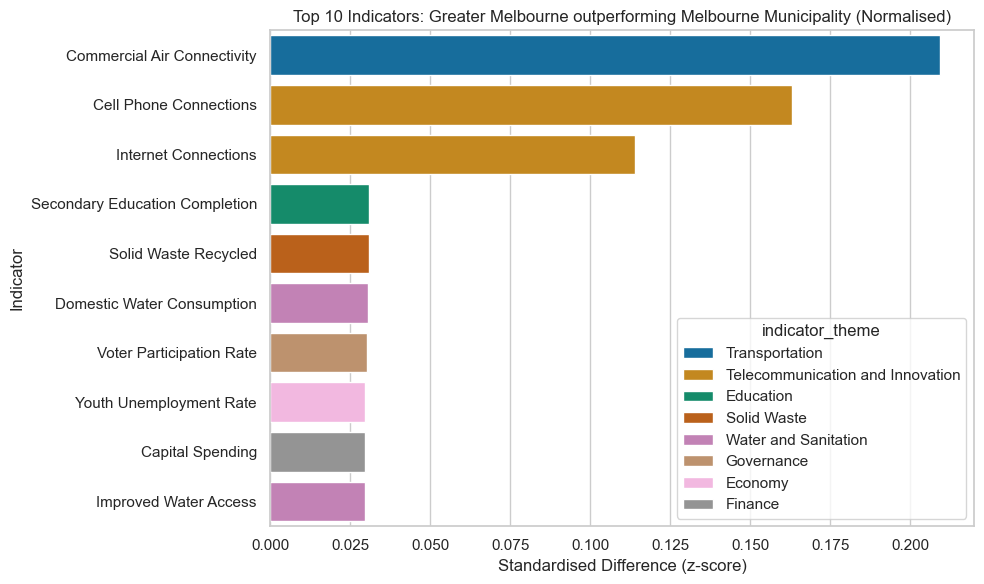

In [22]:
plt.figure(figsize=(10, 6))
sns.barplot(data=top_positive, x='z_diff', y='indicator_variable', hue='indicator_theme', dodge=False)
plt.title("Top 10 Indicators: Greater Melbourne outperforming Melbourne Municipality (Normalised)")
plt.xlabel("Standardised Difference (z-score)")
plt.ylabel("Indicator")
plt.tight_layout()
plt.show()

<h5 class = "use-case-header"> Plotting Underperforming Indicators of Greater Melbourne 

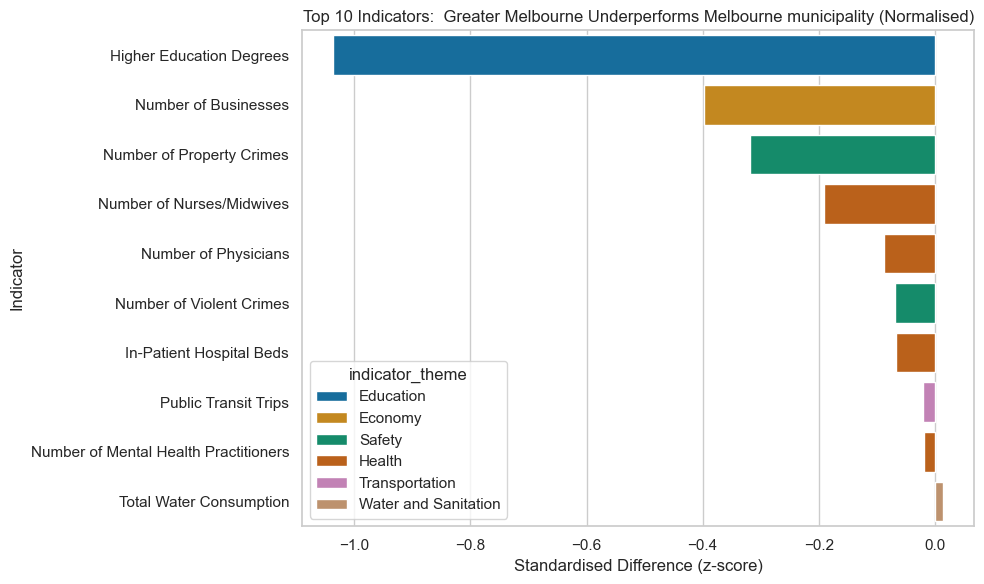

In [23]:

plt.figure(figsize=(10, 6))
sns.barplot(data=top_negative, x='z_diff', y='indicator_variable', hue='indicator_theme', dodge=False)
plt.title("Top 10 Indicators:  Greater Melbourne Underperforms Melbourne municipality (Normalised)")
plt.xlabel("Standardised Difference (z-score)")
plt.ylabel("Indicator")
plt.tight_layout()
plt.show()

<h5 class = "use-case-header"> Having a Deep dive into Top 5 Theme based Indicators.

<p class = "use-case-header"> Top 5 theme that are very fundamental essential for wellbeing that I have chosen for comparison are -

- Health 
- Water and Sanitation
- Environment
- Finance
- Safety

<p class = "use-case-header"> Health Theme Comparison

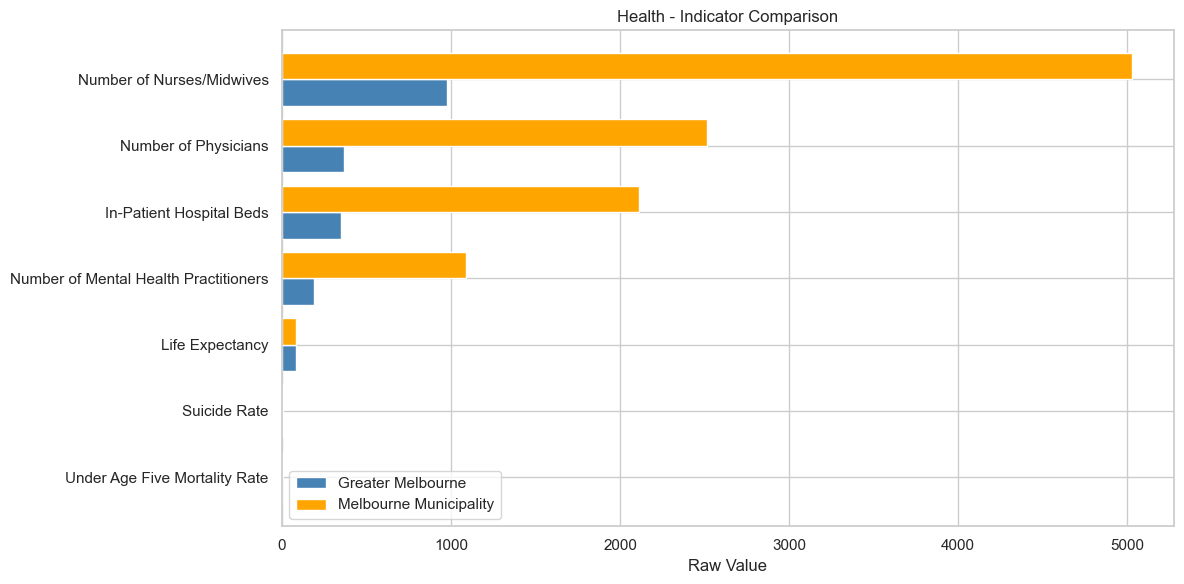

In [24]:
# Health Theme Comparison
health_df = df[df['indicator_theme'] == 'Health'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(health_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], health_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, health_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], health_df['indicator_variable'])
plt.title("Health - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

<p5 class = "use-case-header">Key Insights of Health Domain -
- Healthcare Workforce Gap – Melbourne Municipality far exceeds Greater Melbourne in the number of nurses/midwives and physicians, highlighting stronger healthcare workforce availability in the inner city.
- Hospital Capacity – The municipality also has significantly more in-patient hospital beds, suggesting higher treatment capacity compared to the Greater Melbourne region.
- Mental Health Services – The number of mental health practitioners is much higher in the municipality, showing stronger urban concentration of specialized health services.
- Population Health Outcomes – For indicators like life expectancy, suicide rate, and under-five mortality rate, the values appear relatively close between the two, with no stark difference compared to workforce measures.
- Overall, the chart highlights that Melbourne Municipality has stronger healthcare resources (workforce and infrastructure), while Greater Melbourne shows relative underperformance in healthcare capacity.

<p class = "use-case-header"> Water and Sanitation Theme Comparison

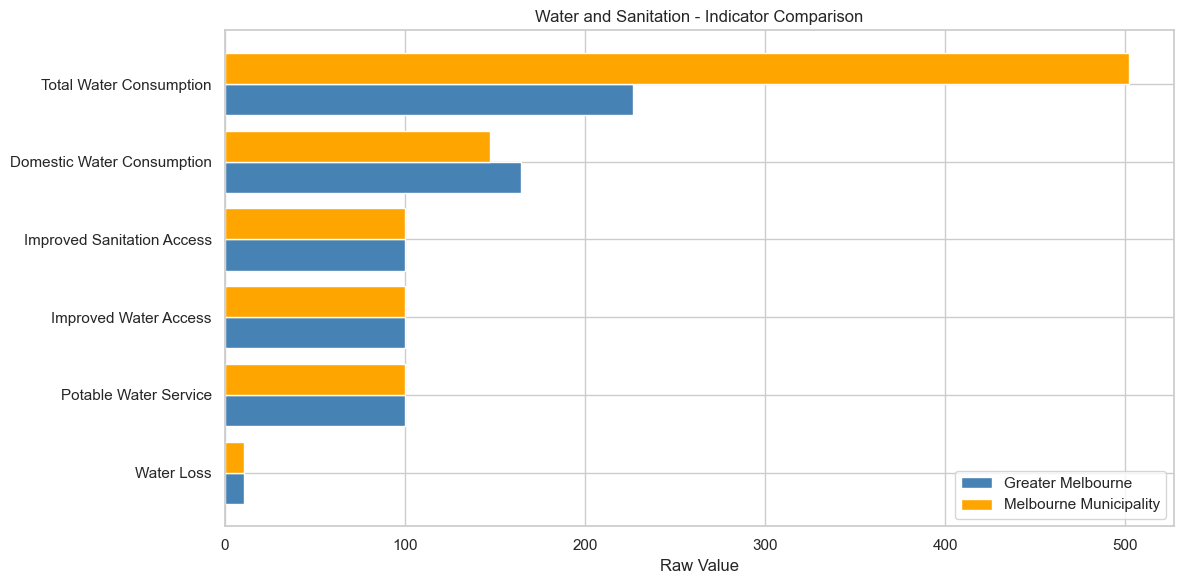

In [25]:
# Water and Sanitation Theme Comparison
water_df = df[df['indicator_theme'] == 'Water and Sanitation'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(water_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], water_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, water_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], water_df['indicator_variable'])
plt.title("Water and Sanitation - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-case-header"> Key insights of Water and Sanitation.

- Total Water Consumption – Melbourne Municipality shows much higher overall water consumption compared to Greater Melbourne, suggesting denser urban usage and greater demand in the city core.

- Domestic Water Consumption – Both areas consume significant amounts, but Greater Melbourne records slightly higher household-level water use, pointing to suburban lifestyles with larger household and garden water needs.

- Access to Services – Indicators for improved sanitation, water access, and potable water service are equal across both, showing universal availability of essential services.

- Water Loss – Minimal in both regions, with almost identical values, indicating efficient water distribution infrastructure.

-  While both areas enjoy reliable sanitation and water services, the municipality faces greater stress due to much higher total water consumption, whereas Greater Melbourne shows slightly higher per-household domestic use.

<p class = "use-case-header"> Environment Theme Comparison

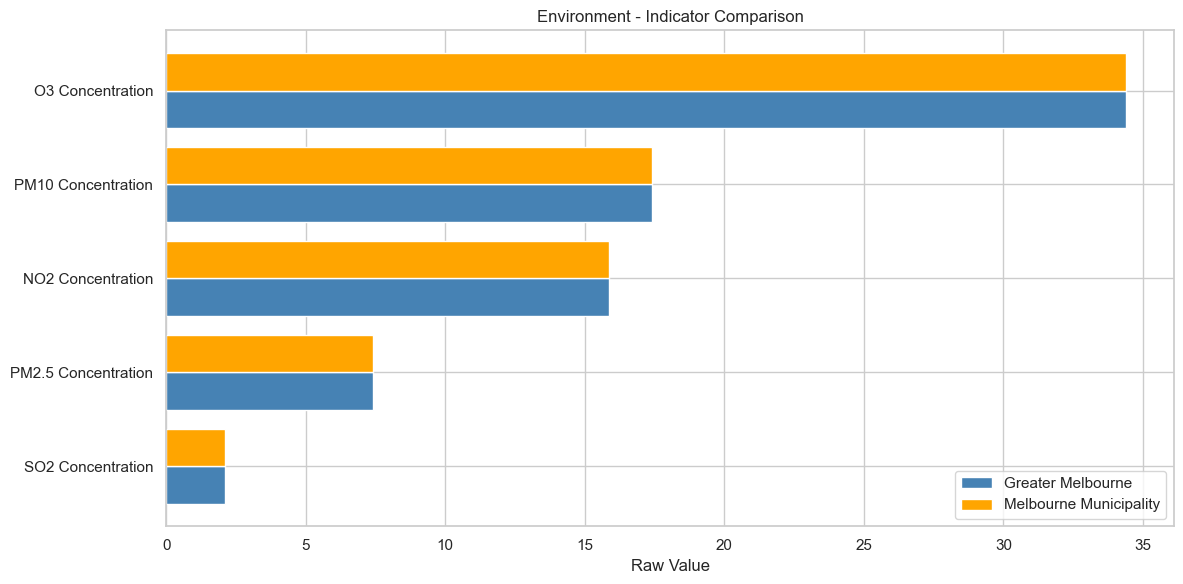

In [26]:
# Environment Theme Comparison
environment_df = df[df['indicator_theme'] == 'Environment'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(environment_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], environment_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, environment_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], environment_df['indicator_variable'])
plt.title("Environment - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-case-header"> Key Insights on Environment

- Ozone (O₃) Concentration – Both Greater Melbourne and Melbourne Municipality show the highest levels here, with nearly identical values, indicating regional air quality challenges linked to ozone.

- Particulate Matter (PM10 & PM2.5) – PM10 levels are similar across both, while Greater Melbourne records slightly higher PM2.5, reflecting broader suburban and industrial contributions to fine particulate pollution.

- Nitrogen Dioxide (NO₂) – Concentrations are comparable, with the municipality showing a marginally lower value, pointing to slightly reduced vehicle or industrial emissions in the urban core.

- Sulfur Dioxide (SO₂) – Levels are very low overall, with negligible difference between Greater Melbourne and the municipality, suggesting minimal sulfur-related pollution sources.

- Air quality pressures are broadly shared across both regions, with ozone and particulate matter being the dominant concerns, while SO₂ remains insignificant.


<p class = "use-case-header"> Finance Theme Comparison

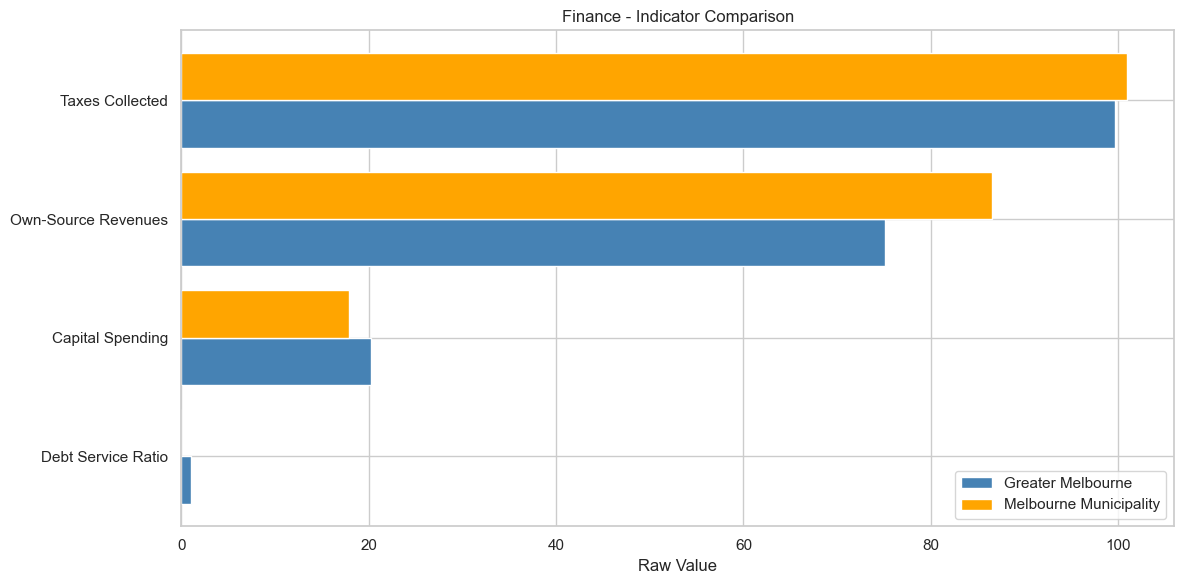

In [27]:
# Finance Theme Comparison
finance_df = df[df['indicator_theme'] == 'Finance'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(finance_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], finance_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, finance_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], finance_df['indicator_variable'])
plt.title("Finance - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class ="use-case-header"> Key Insights on Finance
 
 - Taxes Collected – Both Greater Melbourne and Melbourne Municipality collect high levels of taxes, with the municipality slightly ahead, showing its strong fiscal capacity.

- Own-Source Revenues – Melbourne Municipality generates more revenue from its own sources (like fees, charges, and services) compared to Greater Melbourne, reflecting higher economic activity and self-sufficiency.

- Capital Spending – Greater Melbourne spends more on capital projects (infrastructure, development), indicating larger-scale regional investments, while the municipality allocates relatively less.

- Debt Service Ratio – Both regions maintain very low debt service ratios, pointing to minimal financial risk and strong fiscal sustainability.

- Melbourne Municipality demonstrates stronger revenue generation capacity, while Greater Melbourne leads in capital spending, highlighting a complementary financial profile.

<p class = "use-case-header"> Safety Theme Comparison

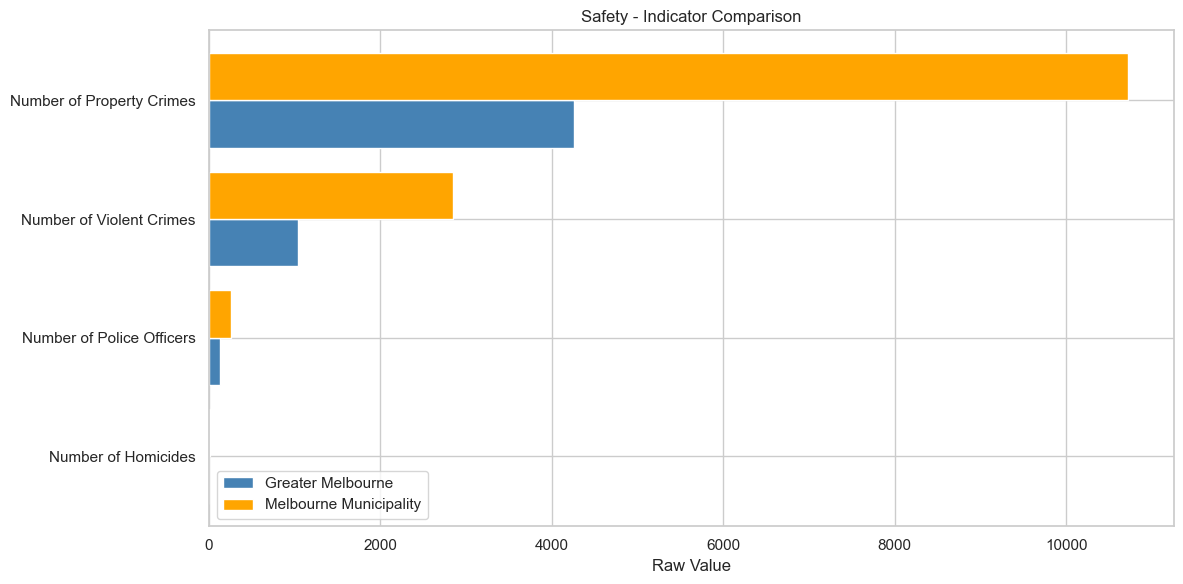

In [28]:
# Safety Theme Comparison
safety_df = df[df['indicator_theme'] == 'Safety'].sort_values(by='greater_melbourne_value', ascending=False)

plt.figure(figsize=(12, 6))
x = range(len(safety_df))
bar_width = 0.4

plt.barh([i + bar_width for i in x], safety_df['greater_melbourne_value'], height=bar_width, label='Greater Melbourne', color='steelblue')
plt.barh(x, safety_df['melbourne_municipality_value'], height=bar_width, label='Melbourne Municipality', color='orange')

plt.yticks([i + bar_width / 2 for i in x], safety_df['indicator_variable'])
plt.title("Safety - Indicator Comparison")
plt.xlabel("Raw Value")
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


<p class = "use-class-header"> Key Insights on Safety

- Property Crimes – Melbourne Municipality records far higher property crimes compared to Greater Melbourne, indicating a significant urban safety challenge.

- Violent Crimes – The municipality also shows more violent crimes, while Greater Melbourne reports fewer cases, reflecting safer conditions at the regional level.

- Police Officers – Both regions report relatively low numbers of police officers compared to the scale of crimes, though the municipality has slightly more.

- Homicides – Values are very low in both regions, showing that serious violent crimes remain rare despite higher general crime rates.

- Crime is concentrated more heavily in the municipality, particularly property and violent offenses, suggesting that urban density and socio-economic pressures may drive higher crime levels compared to Greater Melbourne.

<h5 class = "use-case-header"> Correlation between Indicator theme and Indicator variable

<h5 class ="use-case-header">Normalised Heatmap of Indicator Themes vs Indicator Variables 

<p class ="use-case-header">This is the heatmap of normalised values for fair comparison because different themes have different units so their raw values cannot be compared directly so we will first normalise the values so that they come into common scale valid for comparison.The heatmap is a powerful visualisation that allows comparison of multiple urban wellbeing themes and their related indicators in a single view. By converting numerical values into colour intensities, it simplifies the interpretation of complex datasets. In this context, the heatmap highlights how different themes such as health, education, economy, transportation, and sanitation perform across their respective indicators. Normalisation ensures that large-scale variables do not overshadow smaller ones, making it possible to compare relative strengths and weaknesses fairly. This helps identify which indicators stand out within a theme, which areas are consistently strong, and which ones require improvement, providing a balanced overview of the urban wellbeing landscape.

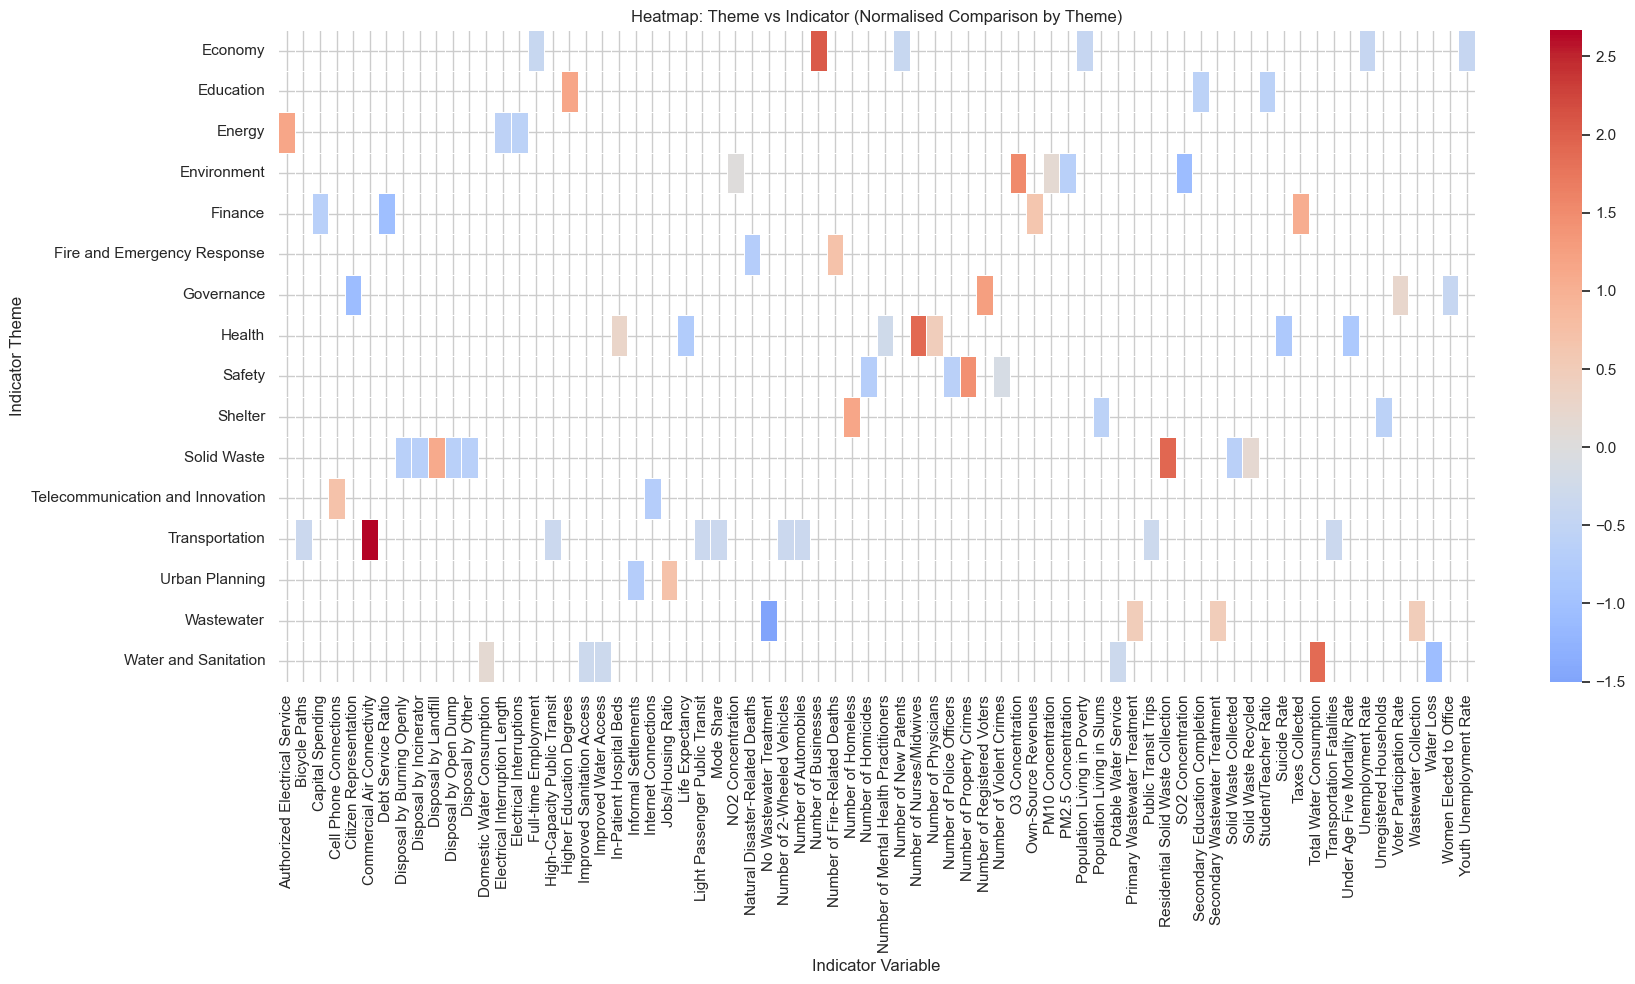

In [30]:
import numpy as np
df['average_value'] = (df['greater_melbourne_value'] + df['melbourne_municipality_value']) / 2


pivot = df.pivot_table(index='indicator_theme',
                       columns='indicator_variable',
                       values='average_value')


row_means = pivot.mean(axis=1, skipna=True)
row_stds  = pivot.std(axis=1, skipna=True).replace(0, np.nan)  
pivot_row_z = (pivot.sub(row_means, axis=0)).div(row_stds, axis=0)

plt.figure(figsize=(18, 10))
sns.heatmap(pivot_row_z,
            cmap="coolwarm", center=0,
            mask=pivot_row_z.isna(),
            linewidths=0.5)
plt.title("Heatmap: Theme vs Indicator (Normalised Comparison by Theme)")
plt.xlabel("Indicator Variable")
plt.ylabel("Indicator Theme")
plt.tight_layout()
plt.show()

<p class = "use-case-header"> Key Insights from the heatmap

- Transportation shows a strong positive outlier for vehicle-related indicators (e.g., number of automobiles), marking it as a dominant internal factor.

- Telecommunication & Innovation has positive deviations around internet/mobile-related indicators, confirming technology access as a standout.

- Solid Waste indicators show mixed performance: some (like collection rates) are above theme-average, while others are below, highlighting internal variability.

- Education stands out positively for enrollment/completion indicators, but not uniformly across all levels.

- Health shows both positive and negative deviations: hospital capacity indicators are stronger, while other health measures are weaker relative to the theme.

- Safety reveals negative deviations overall, suggesting weaker performance across crime-related indicators compared to its internal baseline.

- Environment & Energy exhibit more negative values, implying relative underperformance within their respective themes.

- Economy has a few stronger indicators (e.g., businesses or patents) but unemployment-related variables appear weaker.

- Governance and Fire/Emergency Response are mostly flat to negative, suggesting limited standout indicators compared to other themes.

- Urban Planning, Wastewater, and Water & Sanitation show more balanced distributions, with no extreme positive outliers, meaning performance is relatively uniform within these themes.

<h5 class ="use-case-header">Dendogram of the Public Health and Sanitation

<p class = "use-case-header">The dendrogram is a hierarchical clustering tool that organises indicators based on their similarity, revealing hidden structures in the data. By linking indicators that behave alike, it forms clusters that provide insight into natural groupings, such as healthcare capacity measures, sanitation access variables, or waste management practices. In the case of public health and sanitation, the dendrogram clearly distinguishes between healthcare resources, health outcomes, and environmental infrastructure, while also showing how some health outcomes (like mortality or life expectancy) bridge across domains. This hierarchical arrangement makes it easier to see not only which indicators are related but also how broader categories of wellbeing are interconnected, supporting data-driven prioritisation and planning.

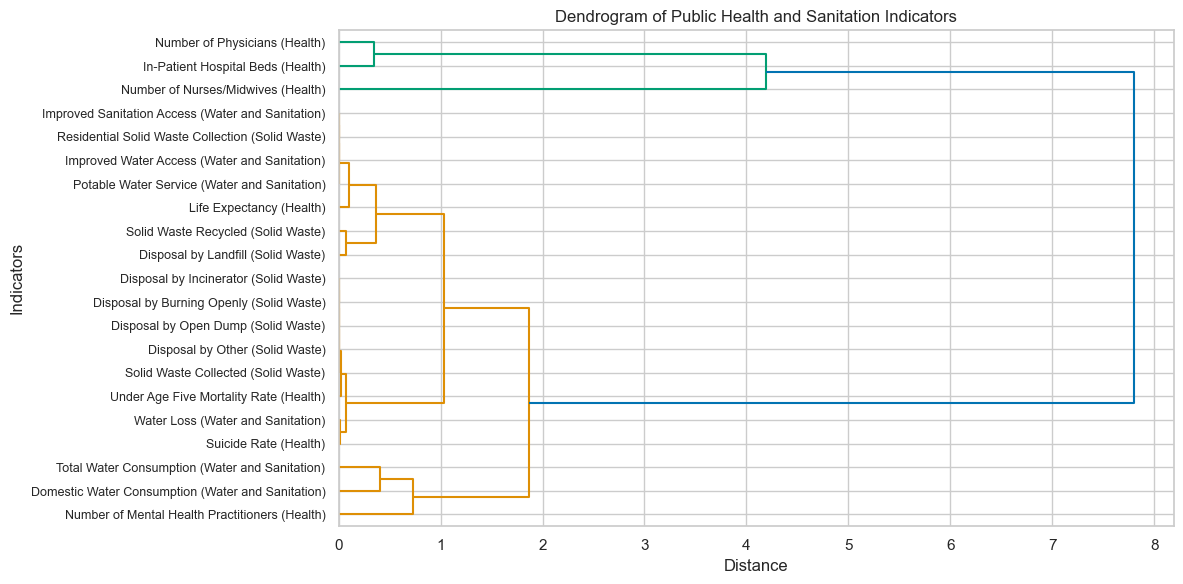

In [31]:
TARGET_THEMES = {"waste water", "water and sanitation", "health", "solid waste"}
VAL_COLS = ["greater_melbourne_value", "melbourne_municipality_value"]
mask = df["indicator_theme"].astype(str).str.casefold().isin(TARGET_THEMES)
sub = df[mask].copy()
X = sub[VAL_COLS].dropna()
if X.shape[0] >= 2:
    if "indicator_variable" in sub.columns:
        labels = sub.loc[X.index, "indicator_variable"] + " (" + sub.loc[X.index, "indicator_theme"] + ")"
        labels = labels.astype(str).tolist()
    else:
        labels = [f"Row {i}" for i in X.index]
    X_scaled = StandardScaler().fit_transform(X.values)
    Z = linkage(X_scaled, method="ward")
    plt.figure(figsize=(12, max(6, X.shape[0]*0.25)))
    dendrogram(
        Z,
        labels=labels,
        orientation="right",
        leaf_font_size=9
    )
    plt.title("Dendrogram of Public Health and Sanitation Indicators")
    plt.xlabel("Distance")
    plt.ylabel("Indicators")
    plt.tight_layout()
    plt.show()

<p class = "use-case-header">

- Physicians, hospital beds, and nurses/midwives cluster together showing healthcare capacity.

- Water and sanitation access indicators cluster together showing basic service infrastructure.

- Waste disposal methods cluster together showing waste management practices.

- Life expectancy, child mortality, and suicide rate cluster with some sanitation indicators showing health outcomes linked to environment.

- Water consumption and mental health practitioners cluster together showing a link between household water use and social wellbeing.

- Overall, indicators separate into healthcare system versus sanitation and waste infrastructure, with health outcomes bridging both.

<h5 class = "use-case-header">PCA for all the Urban Wellbeing Indicators of various themes

<p class = "use-case-header">Principal Component Analysis (PCA) is a dimensionality reduction technique that helps simplify complex datasets by transforming correlated indicators into a smaller number of uncorrelated components. In this case, PCA was applied to the urban wellbeing indicators to identify underlying patterns and reduce redundancy in the data. The explained variance plot shows how much information each component retains, while the scatter plot of the first two principal components (PC1 vs PC2) provides a visual grouping of themes based on similarities across indicators. Together, these outputs help uncover the most influential dimensions of urban wellbeing and reveal natural clusters among themes.

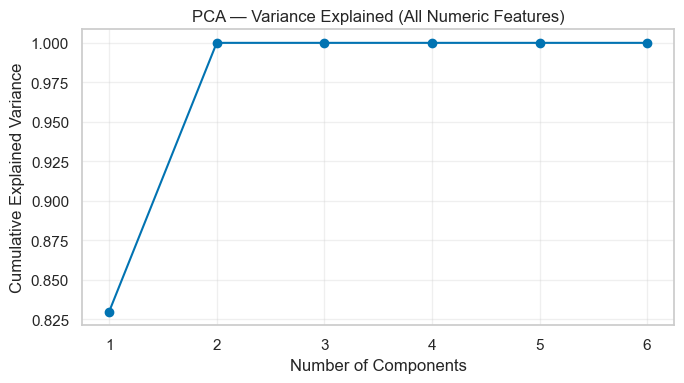

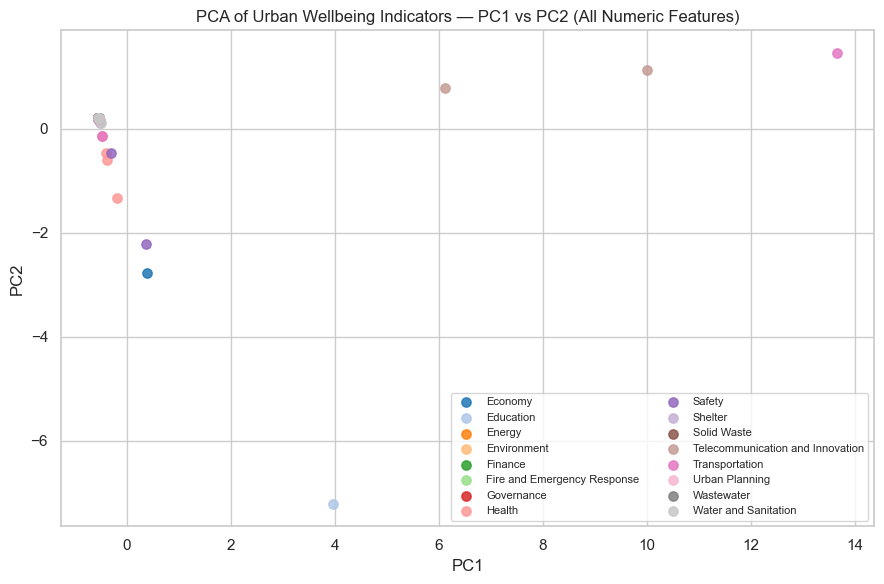

In [32]:
import numpy as np
num_cols = df.select_dtypes(include="number").columns.tolist()
drop_like = ("unnamed", "id", "index", "year") 
feat_cols = [c for c in num_cols if not any(k in c.lower() for k in drop_like)]

X = df[feat_cols].dropna().copy()
meta = df.loc[X.index, ["indicator_theme", "indicator_variable"]].astype(str)
X_scaled = StandardScaler().fit_transform(X.values)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


plt.figure(figsize=(7,4))
cumvar = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, len(cumvar)+1), cumvar, marker="o")
plt.xticks(range(1, len(cumvar)+1))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA — Variance Explained (All Numeric Features)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

pc_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"], index=X.index)
pc_df["theme"] = meta["indicator_theme"].values
pc_df["indicator"] = meta["indicator_variable"].values

themes = pc_df["theme"].unique().tolist()
colors = {t: plt.cm.tab20(i % 20) for i, t in enumerate(themes)}

plt.figure(figsize=(9,6))
for t in themes:
    d = pc_df[pc_df["theme"] == t]
    plt.scatter(d["PC1"], d["PC2"], s=45, alpha=0.85, c=[colors[t]], label=t)
plt.title("PCA of Urban Wellbeing Indicators — PC1 vs PC2 (All Numeric Features)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(loc="best", fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

<p class ="use-class-header">The explained variance plot shows that the first two principal components capture almost 100% of the total variance. This means nearly all the data’s variability can be summarised in just two dimensions, making PCA highly effective for this dataset.
PC1 accounts for the majority of the variance, while PC2 adds only a small amount, confirming that PC1 is the most dominant dimension in separating themes.
In the PC1 vs PC2 scatter plot, themes such as Transportation, Solid Waste, and Telecommunication & Innovation are positioned far from the origin, showing they are strongly distinguished by PC1.
Themes like Economy, Education, Safety, Governance, and Health cluster closer together, indicating shared patterns and less variability across their indicators.
Water and Sanitation, Wastewater, and Urban Planning sit near the center, suggesting they contribute moderately without extreme deviations.
The wide separation of a few themes (e.g., Transportation) versus the clustering of many others highlights which areas of urban wellbeing are most unique and which are more interrelated.The scatter plot of PC1 versus PC2 reveals that themes such as Transportation, Solid Waste, and Telecommunication & Innovation stand out as distinct, while most social dimensions, including Health, Education, Safety, Governance, and Economy, cluster closer together, reflecting shared patterns. Themes like Water and Sanitation, Wastewater, and Urban Planning remain near the center, suggesting moderate contributions without extreme variability. Overall, PCA highlights both the uniqueness of certain infrastructural domains and the interconnected nature of social wellbeing indicators.

<h5 class = "use-case-header">Correlation Matrix of Melbourne Urban Wellbeing Indicators by theme

<p class ="use-case-header">The correlation matrix provides a comprehensive view of the relationships between Melbourne’s urban wellbeing themes. By examining pairwise correlations, we can identify how different domains—such as economy, health, education, environment, and infrastructure—move together. Strong positive correlations suggest that improvements in one area are typically accompanied by improvements in others, while weaker correlations highlight more independent domains. This visualisation helps policymakers and planners understand the interconnectedness of wellbeing indicators, identify synergistic effects, and pinpoint areas requiring distinct strategies.

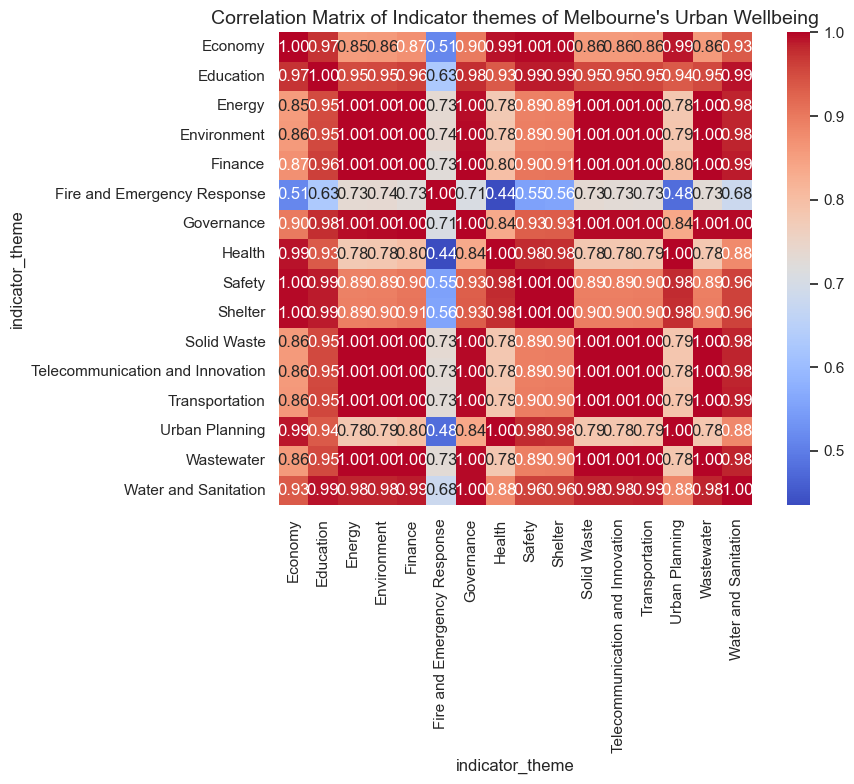

In [ ]:
num_cols = df.select_dtypes(include="number").columns.tolist()
drop_like = ("unnamed", "id", "index", "year")
feat_cols = [c for c in num_cols if not any(k in c.lower() for k in drop_like)]
sub = df.dropna(subset=feat_cols).copy()
theme_means = sub.groupby("indicator_theme")[feat_cols].mean()
theme_corr = theme_means.T.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(
    theme_corr,
    cmap="coolwarm",
    annot=True, fmt=".2f",
    square=True,
    cbar=True
)
plt.title("Correlation Matrix of Indicator themes of Melbourne's Urban Wellbeing", fontsize=14)
plt.tight_layout()
plt.show()

<p class = "use-case-header">

- High overall interdependence
Most themes exhibit very strong positive correlations (0.95–1.00), showing that Melbourne’s urban wellbeing domains are highly interconnected. Progress in one domain (e.g., economy, education, sanitation) is strongly associated with progress in others.

- Health, Economy, Education, and Safety are tightly coupled
These domains are near-perfectly correlated, suggesting that social wellbeing, prosperity, and security tend to move together. This reflects the reinforcing loop between economic stability, quality education, strong health systems, and safe communities.

- Fire and Emergency Response is more independent
This theme shows moderately lower correlations (0.44–0.56) with several others, indicating that emergency preparedness and response do not strongly track improvements in broader wellbeing areas. This makes it a specialized domain requiring focused policy attention.

- Governance and Environment show weaker ties
Compared to core social and economic indicators, Governance and Environment have slightly weaker correlations, suggesting these domains may evolve differently and could act as distinct levers for policy interventions.

- Urban Planning and Infrastructure themes are integrated
Themes such as Solid Waste, Water & Sanitation, and Transportation remain strongly correlated with social themes, reinforcing that infrastructure development is closely tied to quality of life outcomes.

- Policy implication
Since most domains move together, holistic policy interventions will likely yield benefits across multiple areas. However, Fire and Emergency Response, Governance, and Environment require domain-specific strategies because they don’t automatically improve alongside others.

<h5 class = "use-case-header">Cosine similarity of Indicator-Indicator by considering Greater Melbourne and Melbourne Municipality as vectors

<p class = "use-case-header"> The cosine similarity matrix compares Melbourne’s urban wellbeing indicators based on their relative values across Greater Melbourne and the Melbourne Municipality. Each indicator is represented as a two-dimensional vector (one value per city), and cosine similarity is used to measure the alignment between these vectors. A value close to 1 indicates that the indicator behaves consistently across the two geographies, while values closer to 0 indicate divergence. This matrix highlights how similar or distinct the wellbeing indicators are when compared between metropolitan and municipal scales.

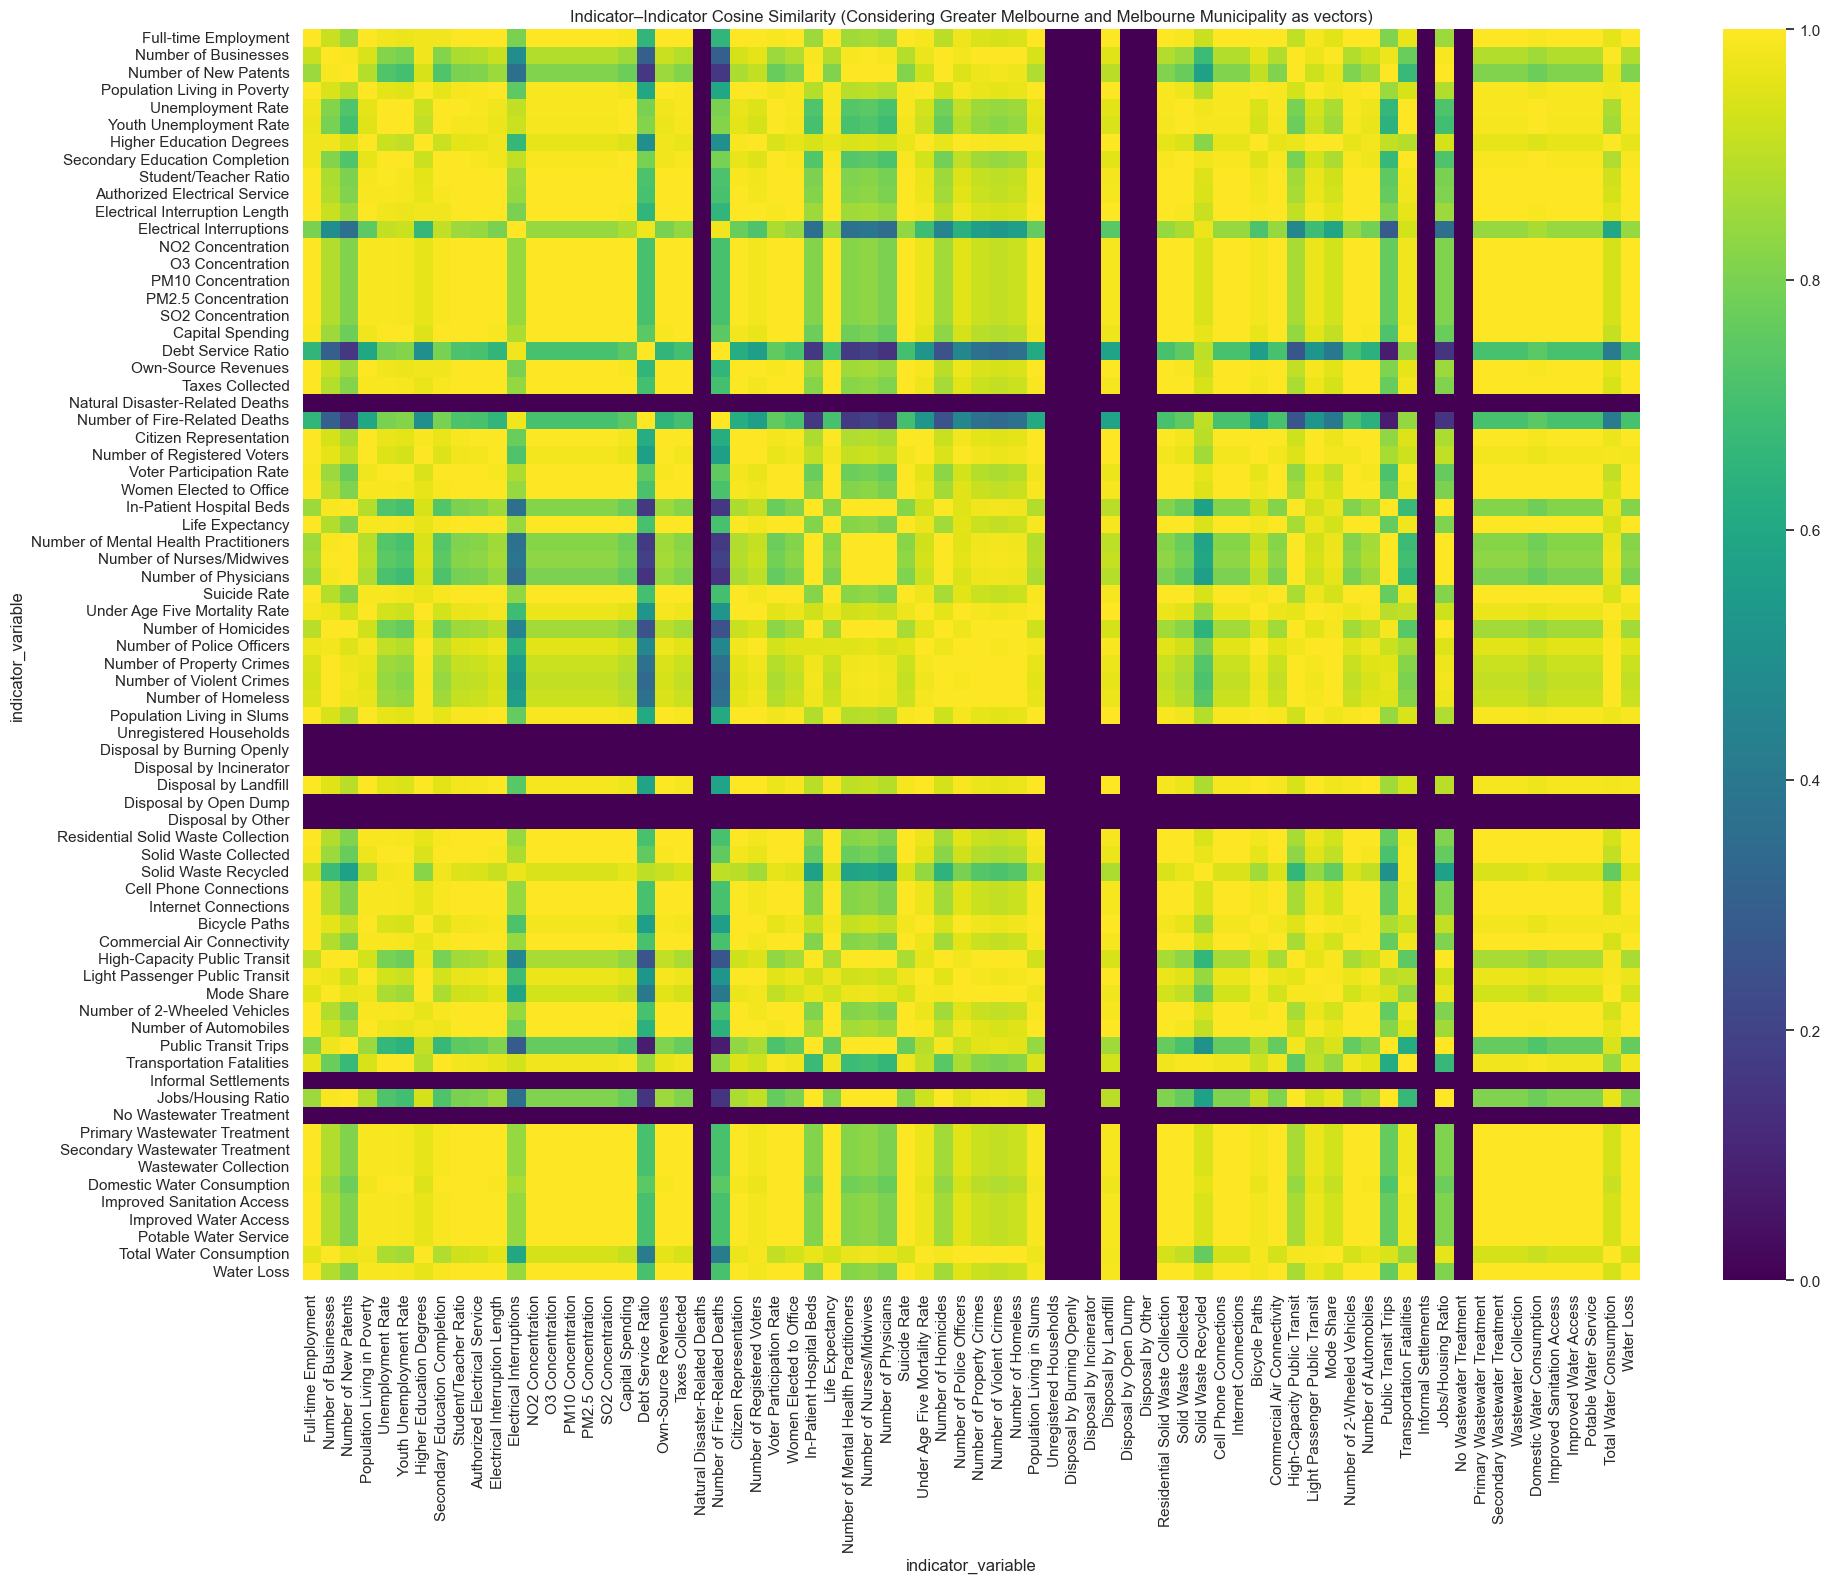

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
X = df[["indicator_variable","greater_melbourne_value","melbourne_municipality_value"]]
X = X.drop_duplicates("indicator_variable").set_index("indicator_variable")


sim = pd.DataFrame(cosine_similarity(X.values), 
                   index=X.index, columns=X.index)


plt.figure(figsize=(20,16))
sns.heatmap(sim, cmap="viridis", vmin=0, vmax=1)
plt.title("Indicator–Indicator Cosine Similarity (Considering Greater Melbourne and Melbourne Municipality as vectors)")
plt.tight_layout()
plt.show()

<p class = "use-case-header">

- High overall similarity: Most indicators show cosine similarity values close to 1.0 (yellow), indicating that Greater Melbourne and the Municipality follow very similar patterns across the majority of wellbeing indicators.

- Clusters of aligned indicators: Groups such as Health (e.g., life expectancy, hospital beds, physicians), Education (school completion, higher education), and Infrastructure (transport access, sanitation, waste management) appear tightly aligned across both cities.

- Independent outliers: Dark purple bands (low similarity) highlight indicators with imbalanced or zero values in one geography, such as waste disposal methods or rare event metrics (e.g., fire-related deaths). These outliers do not co-move with most other indicators.

- Relative comparability: The high similarity suggests that, at the indicator level, Melbourne Municipality broadly reflects the same wellbeing conditions as Greater Melbourne, with only a few specialised exceptions.

- Policy implication: The results indicate that urban wellbeing policies can often be scaled across metro and municipal levels, but targeted interventions may be required for specific outliers (e.g., waste disposal practices, rare-event safety indicators).

<h4 class = "use-case-header"> Results

<p class = "use-case-header">Throughout this use case, I analysed Melbourne’s urban wellbeing across multiple themes using heatmaps, dendrograms, PCA, correlation matrices, and ratio analysis. The results reveal strong interconnections among core domains such as economy, education, health, safety, transport, and sanitation, while governance, environment, and fire & emergency response emerge as more independent areas. The municipality demonstrates clear advantages in health workforce density, public transport use, innovation, and jobs–housing balance, yet lags in secondary education completion, civic participation, and waste treatment practices. These findings highlight both areas of strength and critical gaps that shape Melbourne’s overall wellbeing landscape.

- Municipality has 3–6× higher density of physicians, nurses, hospital beds, and mental health practitioners.

- Municipality records 12× higher public transit trips and stronger high-capacity transport use.

- Municipality far outperforms metro in patents, ICT adoption, and innovation activity.

- Municipality achieves a 6.35× higher jobs–housing ratio, reducing commuting stress.

- Secondary school completion rates in municipality lag below metro averages.

- Voter participation and women’s representation are weaker at the municipal level.

- Higher homicide rates persist in the municipality despite overall governance strength.

- Wastewater treatment is absent in some areas, posing public health risks.

- Recycling and waste reduction practices are limited compared to collection coverage.

- Environmental indicators such as air pollution show weak correlation with social gains, making environment an independent concern.

- Fire & Emergency Response remains the least integrated theme, showing variation in preparedness and outcomes.


<h4 class ="use-case-header"> Recommendations

<p class = "use-case-header">

- Expand transport capacity, reliability, and last-mile connectivity to sustain the municipality’s transit advantage.

- Leverage strong health workforce by shifting resources into preventive and community healthcare.

- Scale up innovation hubs and ICT infrastructure to strengthen patents, startups, and economic growth.

- Address education gaps with programs targeted at boosting secondary school completion.

- Increase civic participation through voter engagement campaigns and improve women’s political representation.

- Target crime hotspots with tailored social interventions to reduce homicide rates.

- Prioritize full wastewater treatment coverage and invest in recycling and circular economy practices.

- Strengthen environmental management with air quality monitoring and urban greening programs.

- Modernise fire and emergency response infrastructure as it operates independently of other wellbeing domains.

- Expand affordable housing options to match strong jobs–housing ratios and reduce housing stress.


<h4 class = "use-case-header"> References

<p class = "use-case-header">

[1] City of Melbourne Open Data Team. (2024, April 22). Indicators of quality of life and city services by year [Data set]. City of Melbourne. https://data.melbourne.vic.gov.au/explore/dataset/indicators-of-quality-of-life-and-city-services-by-year/information/

[2] McKinney, W. (2018). Python for Data Analysis: Data wrangling with Pandas, NumPy, and IPython (2nd ed.). O’Reilly Media. https://wesmckinney.com/book/

[3] Everitt, B. S., Landau, S., Leese, M. & Stahl, D. (2011). Cluster Analysis (5th ed.). Wiley Series in Probability and Statistics. https://doi.org/10.1002/9780470977811

[4] Jolliffe, I. T. & Cadima, J. (2016). Principal component analysis: A review and recent developments. Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences, 374(2065). https://doi.org/10.1098/rsta.2015.0202

[5] Tufte, E. R. (2001). The Visual Display of Quantitative Information (2nd ed.). Graphics Press, Cheshire, CT.
